In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
pd.set_option('display.max_columns', None)

In [9]:
cats=['Home', 'Religion', 'Ethnicity', 'Education', 'Occupation',
       'Income', 'Marital', 'Smoke', 'Smoking', 'Alcohol', 'Partner',
       'P_Education', 'P_Occupation', 'P_Alcohol', 'P_Drugs', 'P_Fights',
       'P_Women', 'P_Child', 'PDEPRESSION',
       'Panxiety', 'PPTSD', 'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age', 'P_Age']
dep="MINIdepression"

In [4]:
from fastai.tabular.all import *

In [10]:
df['P_Age'] = df.P_Age.replace(' ', None)

In [14]:
df['P_Age'] = df.P_Age.fillna(0)

In [16]:
df['P_Age'] = df.P_Age.astype('int64')

In [18]:
splits = RandomSplitter()(df)

In [19]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [26]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0691830962896347, valley=0.013182567432522774)

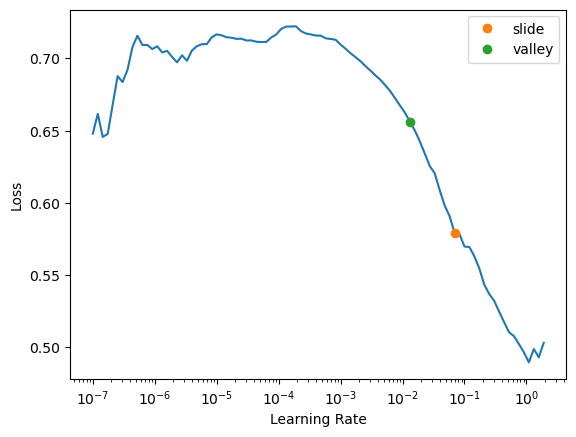

In [21]:
learn.lr_find(suggest_funcs=(slide, valley))

In [22]:
learn.fit(16, lr=0.03)

In [25]:
learn.fit(50, lr=0.03)

In [27]:
learn.fit(18, lr=0.03)

In [29]:
# Checkpoint
# learn.save('model_94')

In [31]:
# Checkpoint Export
# learn.export('model_94_export')

In [32]:
learn.summary()

TabularModel (Input shape: 64 x 26)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 9          True      
____________________________________________________________________________
                     64 x 4              
Embedding                                 20         True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 35         True      
____________________________________________________________________________
                     64 x 4              
Embedding                                 20         True      
Embedding                                 20         True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 12         True     

In [47]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [43]:
trn_split,val_split=splits

In [45]:
trn_split

(#73) [60,18,82,66,30,15,63,68,42,39...]

In [42]:
df.iloc[trn_split]

ID  Home  Age  Religion  Ethnicity  Education  Occupation  Income  \
60  35     1   18         1          1          3           1       2   
18   2     1   17         1          1          2           4       1   
82  50     1   38         1          1          2           1       1   
66  69     2   19         1          1          2           1       1   
30   5     1   16         1          1          1           4       1   
..  ..   ...  ...       ...        ...        ...         ...     ...   
17  70     2   16         1          1          2           4       1   
27  41     1   16         1          1          2           4       1   
20  18     1   15         1          1          2           4       1   
21  21     1   14         1          1          2           1       1   
47  33     1   17         1          1          2           4       1   

    Marital  Smoke  Smoking  Alcohol  Partner  P_Age  P_Education  \
60        1      1        1        6        1     21            4   
18        1      2        2        7        2     18            3   
82        3      3        3        7        1     30            2   
66        1      3        1        7        5     22            5   
30        1      3        3        6        5     19            2   
..      ...    ...      ...      ...      ...    ...          ...   
17        1      3        3        7        1     17            2   
27        1      3        3        7        1     18            3   
20        1      3        1        6        1     18            4   
21        1      2        2        7        5     18            2   
47        1      3        3        7        2     20            5   

    P_Occupation  P_Alcohol  P_Drugs  P_Fights  P_Women  P_Child  SectionCQ1  \
60             5          6        6         2        2        1           3   
18             1          6        6         1        3        2           2   
82             1          5        5         2        2        2           1   
66             1          6        6         3        1        4           2   
30             1          6        6         1        3        5           2   
..           ...        ...      ...       ...      ...      ...         ...   
17             4          6        6         3        4        2           1   
27             1          6        6         3        4        4           2   
20             1          2        1         2        3        5           1   
21             1          5        5         1        2        2           1   
47             5          6        6         3        4        4           3   

    SectionCQ2  SectionCQ3  SectionCQ4  SectionCQ5  SectionCQ6 SectionCQ7  \
60           2           3           2           4           1          2   
18           1           3           1           2           2          1   
82           1           1           1           3           2          2   
66           1           2           1           2           2          2   
30           2           1           1           2           2          2   
..         ...         ...         ...         ...         ...        ...   
17           1           1           3           3           1          2   
27           1           1           1           1           2          2   
20           1           1           2           2           2          2   
21           1           1           1           3           1          2   
47           3           2           2           2           2          2   

    SectionCQ8  SectionCQ9  SectionCQ10  SectionCQ11  SectionCQ12  \
60           2           1            1            1            2   
18           1           2            1            1            1   
82           1           2            2            1            1   
66           2           2            1            1            2   
30           1           2            1            1            2  

Getting base error


Calculating Permutation Importance


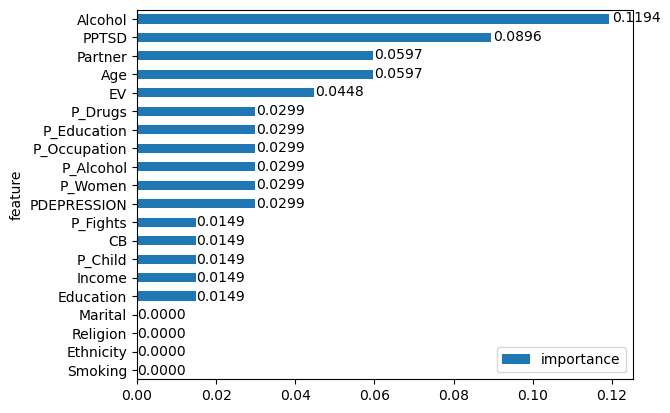

In [48]:
res = PermutationImportance(learn, df.iloc[trn_split], bs=64)